In [1]:
import numpy as np
import matplotlib.pyplot as plt

from colors import C
from fenics import *
from mesh_utils import get_square_f, get_L_mesh
from matrix_free_rsvd import MatrixFreeRSVD, get_approximate_W, tikhonov_solver

set_log_level(30)  # ignore info logging

/home/elias/miniforge3/envs/fenics_env/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Function space
n = 64
mesh = UnitSquareMesh(n, n)
V_h = FunctionSpace(mesh, 'CG', 1)

rsvd = MatrixFreeRSVD(V_h)
print(f"K shape : {rsvd.N_b, rsvd.N}")

K shape : (256, 4225)


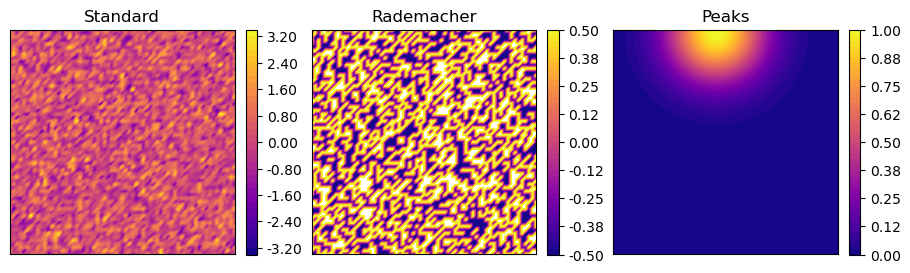

In [3]:
def plot_random_vectors(rsvd: MatrixFreeRSVD):
    V_h = rsvd.V_h
    f_standard = Function(V_h)
    f_rademacher = Function(V_h)
    f_peaks = Function(V_h)

    f_standard.vector()[:] = rsvd.draw_random_vector('standard')
    f_rademacher.vector()[:] = rsvd.draw_random_vector('rademacher')
    f_peaks.vector()[:] = rsvd.draw_random_vector('peaks')

    fig, axes = plt.subplots(1, 3, figsize=(9, 6), constrained_layout=True)
    axes = axes.flatten()

    names = ["Standard", "Rademacher", "Peaks"]
    sols = [f_standard, f_rademacher, f_peaks]
    for ax, func, name in zip(axes, sols, names):
        plt.sca(ax)
        p = plot(func, title=name, cmap='plasma')
        fig.colorbar(p, ax=ax, format="%.2f", shrink=0.38)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()


plot_random_vectors(rsvd)

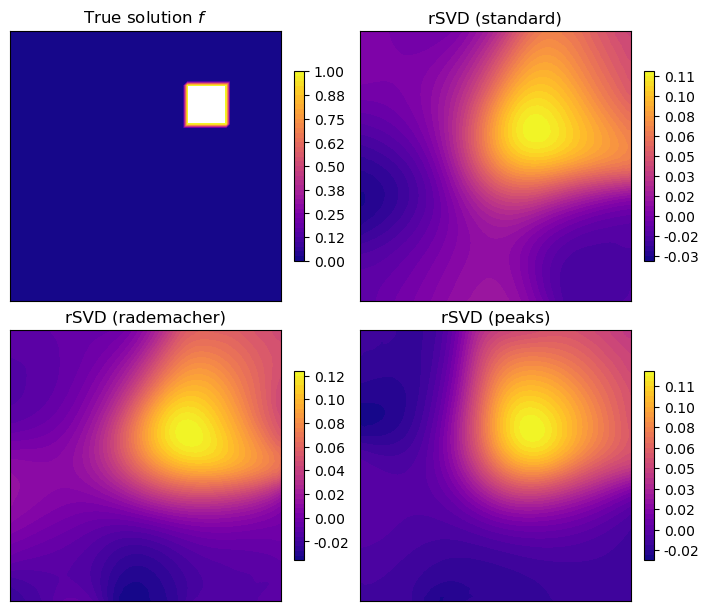

In [4]:
f = get_square_f(V_h, 0.65, 0.65)
x = f.vector().get_local()
y = rsvd.apply_K(x)

k = 4
solutions = [f]
distributions = ['standard', 'rademacher', 'peaks']
for distribution in distributions:

    Uk, Sk, VkT = rsvd.mf_rsvd(k=k, distribution=distribution)
    w = get_approximate_W(Vk=VkT.T, M_dx=rsvd.M_dx)

    # Solve y = (K_k)(x)
    x_hat = tikhonov_solver(rsvd, W_diag=w, y=y, lambda_=1e-3)

    f_hat = Function(V_h)
    f_hat.vector()[:] = x_hat
    solutions.append(f_hat)


def plot_many_f(sols):
    fig, axes = plt.subplots(2, 2, figsize=(7, 6), constrained_layout=True)
    axes = axes.flatten()

    names = [
        "True solution $f$",
        "rSVD (standard)",
        "rSVD (rademacher)",
        "rSVD (peaks)"
    ]
    for ax, func, name in zip(axes, sols, names):
        plt.sca(ax)
        p = plot(func, title=name, cmap='plasma')
        fig.colorbar(p, ax=ax, format="%.2f", shrink=0.7)
        ax.set_xticks([])
        ax.set_yticks([])

plot_many_f(sols=solutions)